In [2]:
### Imports ###
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import spectral.io.envi as envi
from tqdm.contrib import itertools
from time import sleep
from spectral import imshow, view_cube

In [3]:
### Constants ###
h = 6.626e-34 # Planck's constant
c = 299792458 # Speed of light
k = 1.380649e-23 # Boltzmann constant
b = 2.89777e-3 # Wien's constant

# Functions

In [4]:
def blackbody(l, T, e, offset=0):
    """Blackbody radiation equation
    Input: l: wavelength, T: temperature, e: emissivity, 
            offset: used in fitting to account for stray light in the data
    Output: intensity of a blackbody at the given parameters"""
    return (e * ((2 * h * c**2) / l**5) * (1 / (np.exp((h * c) / (l * k * T)) - 1))) + offset

In [5]:
def construct_raw(folder_path):
    """ Constructs the paths to each of the relevant data files
    Input: path to hyperspectral data folder
    Output: list of paths to [raw hdr, raw raw, white reference hdr, white reference raw, 
                            dark reference hdr, dark reference raw, frame index file] """
    print("Constructing paths...")
    retval = []
    retval.append(folder_path + "/raw.hdr")
    retval.append(folder_path + "/raw")
    retval.append(folder_path + "/whiteReference.hdr")
    retval.append(folder_path + "/whiteReference")
    retval.append(folder_path + "/darkReference.hdr")
    retval.append(folder_path + "/darkReference")
    retval.append(folder_path + "/frameIndex.txt")
    return retval

In [6]:
def construct_data(folder_path):
    """ Constructs the paths to each of the relevant data files
    Input: path to hyperspectral data folder
    Output: list of paths to [raw hdr, raw raw, white reference hdr, white reference raw, 
                            dark reference hdr, dark reference raw, frame index file] """
    print("Constructing paths...")
    retval = []
    retval.append(folder_path + "/data.hdr")
    retval.append(folder_path + "/data")
    retval.append(folder_path + "/whiteReference.hdr")
    retval.append(folder_path + "/whiteReference")
    retval.append(folder_path + "/darkReference.hdr")
    retval.append(folder_path + "/darkReference")
    retval.append(folder_path + "/frameIndex.txt")
    return retval

In [7]:
def load_data(paths, quiet=False):
    """Input: paths list generated by (or in format of) construct_paths
    Output: hyperspectral tensor corrected by the white and dark references"""
    print("Loading data...")
    try:
        data_ref = envi.open(paths[0], paths[1])
        white_ref = envi.open(paths[2], paths[3])
        dark_ref = envi.open(paths[4], paths[5])

        white_tensor = np.array(white_ref.load())
        dark_tensor = np.array(dark_ref.load())
        data_tensor = np.array(data_ref.load())
    except:
        print("Load failed, waiting 30 seconds...")
        sleep(30)
        return "FAIL"

    corrected_data = np.divide(
        np.subtract(data_tensor, dark_tensor),
        np.subtract(white_tensor, dark_tensor))

    if not quiet:
        print(corrected_data)
    return corrected_data

In [8]:
def get_bands(paths, quiet=False):
    """Input: paths list generated by (or in format of) construct_paths
    Output: (Array of wavelength bands, wavelength units string)"""
    print("Getting wavelength bands...")
    file = open(paths[0], 'r')
    text = file.read()

    start_id = "\nwavelength = {\n"
    start_index = text.find(start_id) + len(start_id)
    end_id = "\n}\n;AOI height"
    end_index = text.find(end_id)
    wavelengths = text[start_index:end_index]
    wavelengths = np.array(wavelengths.split("\n,"), dtype=np.float32)

    units_id = "wavelength units = "
    units_index = text.find(units_id) + len(units_id)
    units = text[units_index:text.find(start_id)]

    if not quiet:
        print(f"Units = {units}")
        print(f"Number wavelengths = {len(wavelengths)}")
        print(f"Wavelengths: {wavelengths}")
        print(f"Removing wavelengths over 950 nm...")

    # [:339] removes wavelengths 950 to 1000 nm since stray laser light 
    # amplifies intensities at those wavelengths, so we wish to ignore them in 
    # the fitting
    wavelengths = wavelengths[:339]

    return wavelengths

In [9]:
def compress_horiz_slice(data, start_idx, end_idx):
    return np.array([np.divide(np.sum(data[:,start_idx:end_idx,:],axis=1), 
                     end_idx-start_idx)])

def shrink_image(image, chunk_size=10, quiet=False):
    """Blurs an image to reduce it's size
    Input: chunk_size representing the number of pixels to average
    Output: the blurred image"""
    for itera in range(2):
        horiz_slices = []
        for i in range(image.shape[1] // chunk_size):
            start_idx = i * chunk_size
            end_idx = (i + 1) * chunk_size
            if end_idx < image.shape[1]:
                horiz_slices.append(compress_horiz_slice(image, start_idx, end_idx))
            elif start_idx == image.shape[1]:
                continue
            else:
                horiz_slices.append(compress_horiz_slice(image, start_idx, image.shape[1]))

        image = np.concatenate(tuple(horiz_slices), axis=0)

    return image

In [10]:
def fit_spectrum(spectrum, quiet=False, check_units=True):
    """Fits the selected spectrum
    Input: None (uses global variables)
    Output: Fitted parameters, final least squares cost"""
    if check_units:
        print("\nIf this test fails, check lower in this function to adjust wavelenght unit conversion to m")
        print("Checking that units are nm... ", end="")
        assert(units == "nm")
        print("Passed")
    if not quiet:
        print("Fitting spectrum...")

    # params = [a0, a1, a2, offset, T]
    params0 = np.array([1, 1, 1, 0.1, 1000])
    def intensity(params, l):
        e = params[0] + (params[1] * l) + (params[2] * l**2)
        return blackbody(l, params[4], e, params[3])
    
    def residuals(params):
        result = []
        for i in range(len(wavelengths)):
            Si = intensity(params, wavelengths[i] * 1e-9) # assuming units are nm
            St = spectrum[i]
            result.append(Si - St)
        return np.array(result)

    result = least_squares(residuals, params0)

    if not quiet:
        yfit = []
        for l in wavelengths:
            yfit.append(intensity(result.x, l * 1e-9))

        plt.figure(figsize=(5,5))
        plt.scatter(wavelengths, spectrum, s=5)
        plt.scatter(wavelengths, yfit, s=5)
        plt.title(f"Fitted Spectrum for Position ({pixel[0]}, {pixel[1]})", fontsize=15)
        plt.xlabel(f"Wavelength [{units}]", fontsize=12)
        plt.xticks(fontsize=10)
        plt.ylabel("Intensity [arb. units]", fontsize=12)
        plt.yticks([])
        plt.legend(["Actual", "Fitted"], fontsize=10)
        plt.show()

    return result.x, result.cost

# Wavelengths

In [41]:
file = open("./2024_08_05_12_37_47/data.hdr", 'r')
text = file.read()

start_id = "\nwavelength = {\n"
start_index = text.find(start_id) + len(start_id)
end_id = "\n}\n;AOI height"
end_index = text.find(end_id)
wavelengths = text[start_index:end_index]
wavelengths = np.array(wavelengths.split("\n,"), dtype=np.float32)

units_id = "wavelength units = "
units_index = text.find(units_id) + len(units_id)
units = text[units_index:text.find(start_id)]

quiet = False
if not quiet:
    print(f"Units = {units}")
    print(f"Number wavelengths = {len(wavelengths)}")
    print(f"Wavelengths: {wavelengths}")
    print(f"Removing wavelengths over 950 nm...")

# [:339] removes wavelengths 950 to 1000 nm since stray laser light 
# amplifies intensities at those wavelengths, so we wish to ignore them in 
# the fitting
wavelengths = wavelengths[:339]

wavelengths

Units = nm
Number wavelengths = 371
Wavelengths: [ 399.471  401.098  402.725  404.351  405.978  407.605  409.232  410.858
  412.485  414.112  415.738  417.365  418.992  420.619  422.245  423.872
  425.499  427.126  428.752  430.379  432.006  433.633  435.259  436.886
  438.513  440.14   441.766  443.393  445.02   446.647  448.273  449.9
  451.527  453.153  454.78   456.407  458.034  459.66   461.287  462.914
  464.541  466.167  467.794  469.421  471.048  472.674  474.301  475.928
  477.555  479.181  480.808  482.435  484.062  485.688  487.315  488.942
  490.569  492.195  493.822  495.449  497.075  498.702  500.329  501.956
  503.582  505.209  506.836  508.463  510.089  511.716  513.343  514.97
  516.596  518.223  519.85   521.477  523.103  524.73   526.357  527.984
  529.61   531.237  532.864  534.491  536.117  537.744  539.371  540.997
  542.624  544.251  545.878  547.504  549.131  550.758  552.385  554.011
  555.638  557.265  558.892  560.518  562.145  563.772  565.399  567.025
  568

array([399.471, 401.098, 402.725, 404.351, 405.978, 407.605, 409.232,
       410.858, 412.485, 414.112, 415.738, 417.365, 418.992, 420.619,
       422.245, 423.872, 425.499, 427.126, 428.752, 430.379, 432.006,
       433.633, 435.259, 436.886, 438.513, 440.14 , 441.766, 443.393,
       445.02 , 446.647, 448.273, 449.9  , 451.527, 453.153, 454.78 ,
       456.407, 458.034, 459.66 , 461.287, 462.914, 464.541, 466.167,
       467.794, 469.421, 471.048, 472.674, 474.301, 475.928, 477.555,
       479.181, 480.808, 482.435, 484.062, 485.688, 487.315, 488.942,
       490.569, 492.195, 493.822, 495.449, 497.075, 498.702, 500.329,
       501.956, 503.582, 505.209, 506.836, 508.463, 510.089, 511.716,
       513.343, 514.97 , 516.596, 518.223, 519.85 , 521.477, 523.103,
       524.73 , 526.357, 527.984, 529.61 , 531.237, 532.864, 534.491,
       536.117, 537.744, 539.371, 540.997, 542.624, 544.251, 545.878,
       547.504, 549.131, 550.758, 552.385, 554.011, 555.638, 557.265,
       558.892, 560.

# 12_37

ImageView object:
  Display bands       :  (100, 100, 100)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 0.2976329028606415]
    G: [0.0, 0.2976329028606415]
    B: [0.0, 0.2976329028606415]

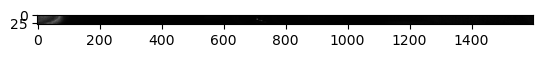

In [42]:
folder = "2024_08_05_12_37_47"
data_ref = envi.open(folder + "/data.hdr", folder + "/data")
data_tensor = np.array(data_ref.load())
imshow(data_tensor, (100,100,100))

ImageView object:
  Display bands       :  (100, 100, 100)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0011955833761021495, 0.14167098701000214]
    G: [0.0011955833761021495, 0.14167098701000214]
    B: [0.0011955833761021495, 0.14167098701000214]

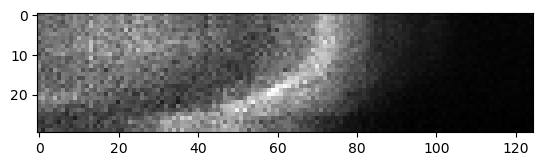

In [43]:
cut_12_37 = data_tensor[:,:125,:]
imshow(cut_12_37,(100,100,100))

In [44]:
temp_12_37 = np.zeros((cut_12_37.shape[0], cut_12_37.shape[1]))
for (i,j) in itertools.product(range(cut_12_37.shape[0]), range(cut_12_37.shape[1])):
    # [:339] removes wavelengths 950 to 1000 nm since stray laser light 
    # amplifies intensities at those wavelengths, so we wish to ignore them in 
    # the fitting
    spectrum = cut_12_37[i][j][:339]
    try:
        result, cost = fit_spectrum(spectrum, quiet=True, check_units=False)
        temp_12_37[i][j] = result[-1]
    except: temp_12_37[i][j] = -1

np.save("./temp_12_37", temp_12_37)

  0%|          | 0/3750 [00:00<?, ?it/s]

/var/folders/mp/t1mxzpdx7k3522x6km17zjf40000gn/T/ipykernel_31511/3705668461.py:6: RuntimeWarning: overflow encountered in exp
  return (e * ((2 * h * c**2) / l**5) * (1 / (np.exp((h * c) / (l * k * T)) - 1))) + offset


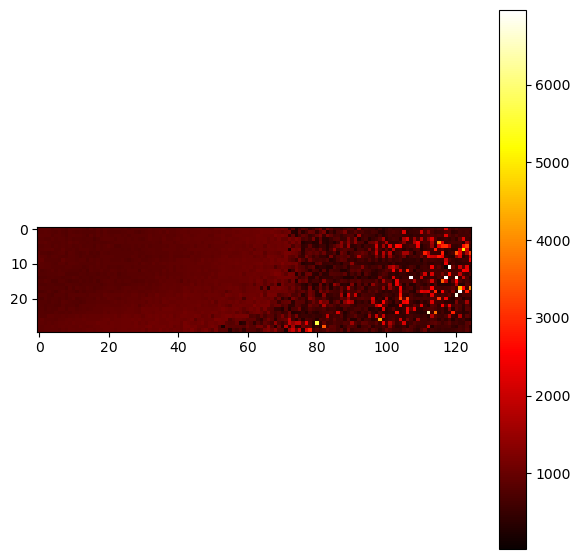

In [45]:
plt.figure(figsize=(7,7))
plt.imshow(temp_12_37, cmap="hot")
plt.colorbar()
plt.show()

# 12_52

ImageView object:
  Display bands       :  (100, 100, 100)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 0.28875675797462463]
    G: [0.0, 0.28875675797462463]
    B: [0.0, 0.28875675797462463]

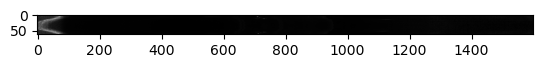

In [46]:
folder = "2024_08_05_12_52_02"
data_ref = envi.open(folder + "/data.hdr", folder + "/data")
data_tensor = np.array(data_ref.load())
imshow(data_tensor, (100,100,100))

ImageView object:
  Display bands       :  (100, 100, 100)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0004161464748904109, 0.2136794775724411]
    G: [0.0004161464748904109, 0.2136794775724411]
    B: [0.0004161464748904109, 0.2136794775724411]

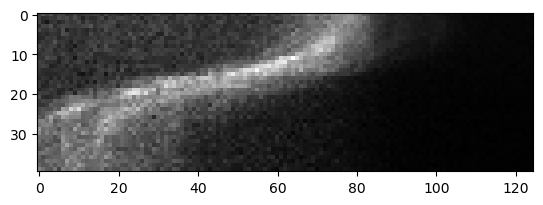

In [47]:
cut_12_52 = data_tensor[:40,:125,:]
imshow(cut_12_52,(100,100,100))

In [48]:
temp_12_52 = np.zeros((cut_12_52.shape[0], cut_12_52.shape[1]))
for (i,j) in itertools.product(range(cut_12_52.shape[0]), range(cut_12_52.shape[1])):
    # [:339] removes wavelengths 950 to 1000 nm since stray laser light 
    # amplifies intensities at those wavelengths, so we wish to ignore them in 
    # the fitting
    spectrum = cut_12_52[i][j][:339]
    try:
        result, cost = fit_spectrum(spectrum, quiet=True, check_units=False)
        temp_12_52[i][j] = result[-1]
    except: temp_12_52[i][j] = -1

np.save("./temp_12_52", temp_12_52)

  0%|          | 0/5000 [00:00<?, ?it/s]

/var/folders/mp/t1mxzpdx7k3522x6km17zjf40000gn/T/ipykernel_31511/3705668461.py:6: RuntimeWarning: overflow encountered in exp
  return (e * ((2 * h * c**2) / l**5) * (1 / (np.exp((h * c) / (l * k * T)) - 1))) + offset


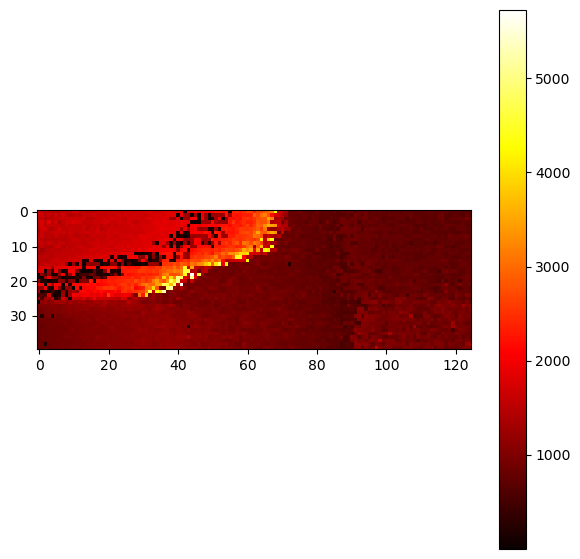

In [59]:
plt.figure(figsize=(7,7))
plt.imshow(temp_12_52, cmap="hot")
plt.colorbar()
plt.show()

# 12_57

ImageView object:
  Display bands       :  (100, 100, 100)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 0.719241201877594]
    G: [0.0, 0.719241201877594]
    B: [0.0, 0.719241201877594]

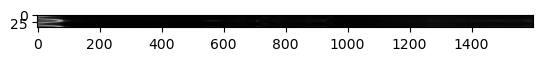

In [49]:
folder = "2024_08_05_12_57_43"
data_ref = envi.open(folder + "/data.hdr", folder + "/data")
data_tensor = np.array(data_ref.load())
imshow(data_tensor, (100,100,100))

ImageView object:
  Display bands       :  (100, 100, 100)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.006252195220440626, 0.6982401609420776]
    G: [0.006252195220440626, 0.6982401609420776]
    B: [0.006252195220440626, 0.6982401609420776]

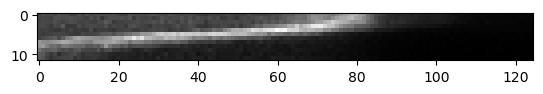

In [50]:
cut_12_57 = data_tensor[:12,:125,:]
imshow(cut_12_57,(100,100,100))

In [51]:
temp_12_57 = np.zeros((cut_12_57.shape[0], cut_12_57.shape[1]))
for (i,j) in itertools.product(range(cut_12_57.shape[0]), range(cut_12_57.shape[1])):
    # [:339] removes wavelengths 950 to 1000 nm since stray laser light 
    # amplifies intensities at those wavelengths, so we wish to ignore them in 
    # the fitting
    spectrum = cut_12_57[i][j][:339]
    try:
        result, cost = fit_spectrum(spectrum, quiet=True, check_units=False)
        temp_12_57[i][j] = result[-1]
    except: temp_12_57[i][j] = -1

np.save("./temp_12_57", temp_12_57)

  0%|          | 0/1500 [00:00<?, ?it/s]

/var/folders/mp/t1mxzpdx7k3522x6km17zjf40000gn/T/ipykernel_31511/3705668461.py:6: RuntimeWarning: overflow encountered in exp
  return (e * ((2 * h * c**2) / l**5) * (1 / (np.exp((h * c) / (l * k * T)) - 1))) + offset


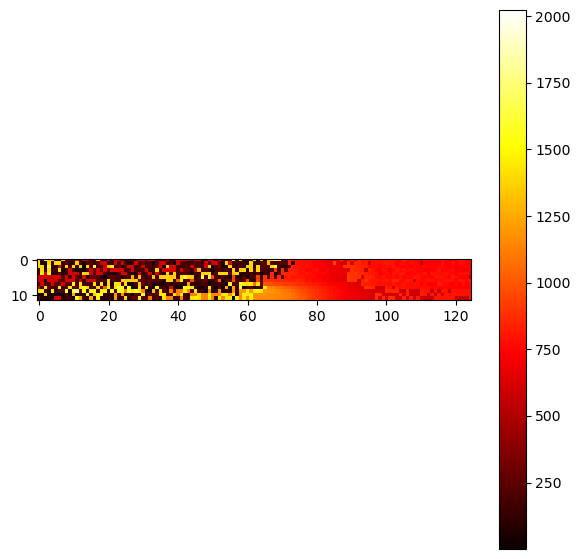

In [60]:
plt.figure(figsize=(7,7))
plt.imshow(temp_12_57, cmap="hot")
plt.colorbar()
plt.show()

# 3_36

ImageView object:
  Display bands       :  (100, 100, 100)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 0.39387649297714233]
    G: [0.0, 0.39387649297714233]
    B: [0.0, 0.39387649297714233]

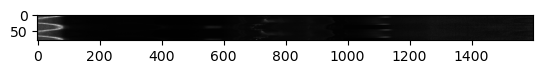

In [52]:
folder = "2024_08_05_15_36_23"
data_ref = envi.open(folder + "/data.hdr", folder + "/data")
data_tensor = np.array(data_ref.load())
imshow(data_tensor, (100,100,100))

ImageView object:
  Display bands       :  (100, 100, 100)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0036142016761004925, 0.3906005322933197]
    G: [0.0036142016761004925, 0.3906005322933197]
    B: [0.0036142016761004925, 0.3906005322933197]

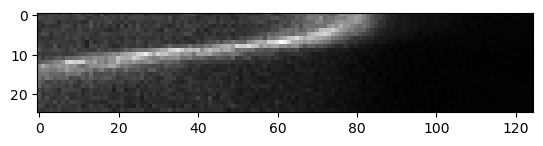

In [53]:
cut_15_36 = data_tensor[:25,:125,:]
imshow(cut_15_36,(100,100,100))

In [54]:
temp_15_36 = np.zeros((cut_15_36.shape[0], cut_15_36.shape[1]))
for (i,j) in itertools.product(range(cut_15_36.shape[0]), range(cut_15_36.shape[1])):
    # [:339] removes wavelengths 950 to 1000 nm since stray laser light 
    # amplifies intensities at those wavelengths, so we wish to ignore them in 
    # the fitting
    spectrum = cut_15_36[i][j][:339]
    try:
        result, cost = fit_spectrum(spectrum, quiet=True, check_units=False)
        temp_15_36[i][j] = result[-1]
    except: temp_15_36[i][j] = -1

np.save("./temp_15_36", temp_15_36)

  0%|          | 0/3125 [00:00<?, ?it/s]

/var/folders/mp/t1mxzpdx7k3522x6km17zjf40000gn/T/ipykernel_31511/3705668461.py:6: RuntimeWarning: overflow encountered in exp
  return (e * ((2 * h * c**2) / l**5) * (1 / (np.exp((h * c) / (l * k * T)) - 1))) + offset


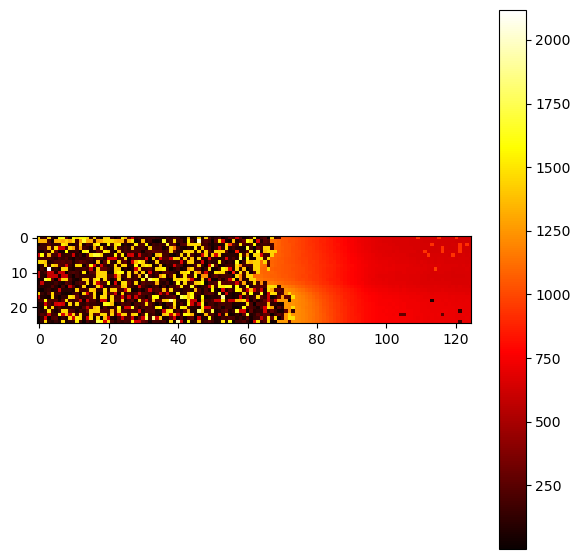

In [61]:
plt.figure(figsize=(7,7))
plt.imshow(temp_15_36, cmap="hot")
plt.colorbar()
plt.show()

# 4_07

ImageView object:
  Display bands       :  (100, 100, 100)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 0.39387649297714233]
    G: [0.0, 0.39387649297714233]
    B: [0.0, 0.39387649297714233]

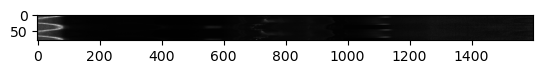

In [55]:
folder = "2024_08_05_15_36_23"
data_ref = envi.open(folder + "/data.hdr", folder + "/data")
data_tensor = np.array(data_ref.load())
imshow(data_tensor, (100,100,100))

# 5_13

ImageView object:
  Display bands       :  (100, 100, 100)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.005396738648414612, 0.6559633016586304]
    G: [0.005396738648414612, 0.6559633016586304]
    B: [0.005396738648414612, 0.6559633016586304]

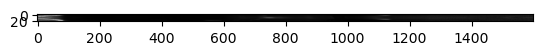

In [56]:
folder = "2024_08_05_17_13_38"
data_ref = envi.open(folder + "/data.hdr", folder + "/data")
data_tensor = np.array(data_ref.load())
imshow(data_tensor, (100,100,100))

ImageView object:
  Display bands       :  (100, 100, 100)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.01046124566346407, 0.6062663197517395]
    G: [0.01046124566346407, 0.6062663197517395]
    B: [0.01046124566346407, 0.6062663197517395]

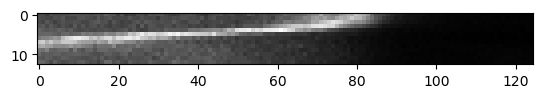

In [57]:
cut_17_13 = data_tensor[:13,:125,:]
imshow(cut_17_13,(100,100,100))

In [58]:
temp_17_13 = np.zeros((cut_17_13.shape[0], cut_17_13.shape[1]))
for (i,j) in itertools.product(range(cut_17_13.shape[0]), range(cut_17_13.shape[1])):
    # [:339] removes wavelengths 950 to 1000 nm since stray laser light 
    # amplifies intensities at those wavelengths, so we wish to ignore them in 
    # the fitting
    spectrum = cut_17_13[i][j][:339]
    try:
        result, cost = fit_spectrum(spectrum, quiet=True, check_units=False)
        temp_17_13[i][j] = result[-1]
    except: temp_17_13[i][j] = -1

np.save("./temp_17_13", temp_17_13)

  0%|          | 0/1625 [00:00<?, ?it/s]

/var/folders/mp/t1mxzpdx7k3522x6km17zjf40000gn/T/ipykernel_31511/3705668461.py:6: RuntimeWarning: overflow encountered in exp
  return (e * ((2 * h * c**2) / l**5) * (1 / (np.exp((h * c) / (l * k * T)) - 1))) + offset


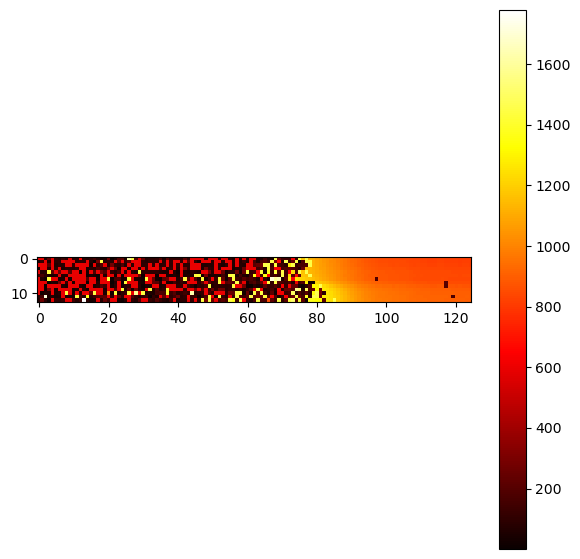

In [62]:
plt.figure(figsize=(7,7))
plt.imshow(temp_17_13, cmap="hot")
plt.colorbar()
plt.show()